In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd -q ..

In [3]:
import lcpfn 
import torch 
import torch as th
import json
import os
import numpy as np
from matplotlib import pyplot as plt

In [79]:
def readDatasetJson(path):
    f = open(path)

    dataset = json.load(f)
    # print(len(dataset))
    
    x = []
    y = []

    for v in dataset.values():
        x.append(v[0])
        y.append(v[1])
        
    x_true = th.Tensor(x)
    y_true = th.Tensor(y)
    
    return x_true, y_true

def find_file(root_dir, target_filename):
    for root, dirs, files in os.walk(root_dir):
        if target_filename in files:
            return os.path.join(root, target_filename)
    
    # If the loop completes without returning, the file was not found
    return None

def find_data():
    return find_file(os.getcwd(), 'data.json')

def get_data():
    return readDatasetJson(find_data())

def get_test_batch(
    batch_size,
    num_features = 1,
    seq_len = 26,
    device = "cpu",
):
    assert num_features == 1

    x_data, y_data = get_data()
   
    x_data = x_data[3302-batch_size:, :]
    y_data = y_data[3302-batch_size:, :]
    
    y_data_noisy = y_data.clone()
    
    x_data = x_data.view((num_features, batch_size, seq_len)).transpose(2, 0).to(device)
    y_data = y_data.transpose(1, 0).to(device)
    y_data_noisy = y_data.clone()

    return x_data, y_data, y_data_noisy

def get_random(num_features=1, seq_len=26, device='cpu'):
    assert num_features == 1
    x_data, y_data = get_data()
    ind = np.random.randint(0, 3302)
    x_data = x_data[ind, :]
    y_data = y_data[ind, :]

    print(x_data.shape)
    print(y_data.shape)

    # x_data = x_data.view((num_features, 1, seq_len)).transpose(2, 0).to(device)
    # y_data = y_data.transpose(1, 0).to(device)
    return x_data, y_data

def get_batch(
    batch_size,
    seq_len,
    num_features,
    device="cpu",
    noisy_target=True,
    **_,
):
    assert num_features == 1

    x_data, y_data = get_data()
    print(x_data.shape)
    x_data = x_data[:batch_size, :]
    y_data = y_data[:batch_size, :]

    y_data_noisy = y_data.clone()

    x_data = x_data.view((num_features, batch_size, seq_len)).transpose(2, 0).to(device)
    y_data = y_data.transpose(1, 0).to(device)
    y_data_noisy = y_data.clone()

    return x_data, y_data, y_data_noisy

## Load trained LC-PFN model

In [80]:
result = lcpfn.train_lcpfn(get_batch_func=get_batch, 
                         seq_len=26,
                         emsize=256,
                         nlayers=12,
                         lr=0.001,
                         batch_size=1651,
                         epochs=0)

result[2].load_state_dict(th.load("/home/patrik/new/dl/reproducibility/deep-learning-project/notebooks/model_1651.pth"))
model = result[2]

model = lcpfn.LCPFN(model)

Using cpu:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 1651, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7de9b49a3160>, 'seq_len_maximum': 26, 'device': 'cpu:0', 'num_features': 1, 'hyperparameters': {}}, 'num_features': 1}
torch.Size([3302, 26])
Style definition: None
Using a Transformer with 6.46 M parameters


## Generate a learning curve from the prior

(0.0, 1.0)

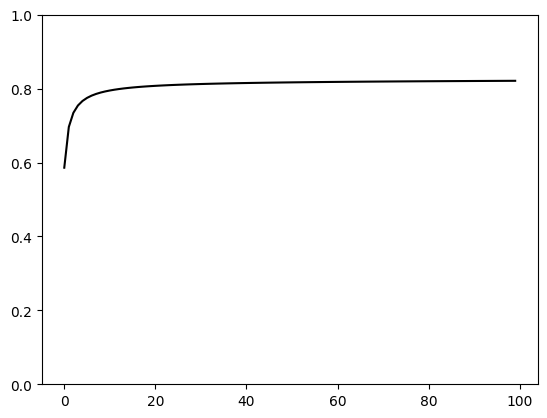

In [81]:
prior = lcpfn.sample_from_prior(np.random)
curve, _ = prior()
plt.plot(curve, "black")
plt.ylim(0, 1)

## Extrapolate the learning curve with a cutoff of 10% 

In [82]:
curve

array([0.58595502, 0.69629716, 0.73451529, 0.75428126, 0.76649555,
       0.77485172, 0.7809587 , 0.78563378, 0.78933788, 0.79235154,
       0.79485571, 0.79697261, 0.79878785, 0.80036331, 0.80174484,
       0.80296719, 0.80405721, 0.80503595, 0.8059202 , 0.80672348,
       0.80745683, 0.80812937, 0.80874867, 0.80932107, 0.80985196,
       0.81034591, 0.81080683, 0.81123812, 0.8116427 , 0.81202312,
       0.81238162, 0.81272016, 0.81304048, 0.81334411, 0.81363242,
       0.81390664, 0.81416785, 0.81441704, 0.81465509, 0.81488281,
       0.8151009 , 0.81531004, 0.81551081, 0.81570377, 0.81588941,
       0.81606819, 0.81624052, 0.81640679, 0.81656736, 0.81672255,
       0.81687266, 0.81701797, 0.81715874, 0.81729521, 0.81742761,
       0.81755614, 0.817681  , 0.81780236, 0.81792039, 0.81803526,
       0.81814711, 0.81825608, 0.81836229, 0.81846588, 0.81856695,
       0.81866562, 0.81876198, 0.81885613, 0.81894816, 0.81903816,
       0.81912621, 0.81921238, 0.81929675, 0.81937939, 0.81946

In [111]:
# construct 

# x = torch.arange(1, 101).unsqueeze(1)
# y = torch.from_numpy(curve).float().unsqueeze(1)
# cutoff = 10

x, y = get_random()
x = x.squeeze(dim=-1)
cutoff = 13


torch.Size([26])
torch.Size([26])


In [112]:
x.shape

torch.Size([26])

In [113]:
y.shape

torch.Size([26])

In [114]:
#predictions = model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])

predictions = model.forward(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:])
predictions = predictions.squeeze(-1)


torch.Size([13])

In [115]:
cutoff

13

In [116]:
y

tensor([0.9052, 0.9051, 0.9113, 0.9101, 0.9099, 0.9059, 0.9067, 0.9092, 0.9219,
        0.9130, 0.9187, 0.9200, 0.9219, 0.9187, 0.9078, 0.9114, 0.9109, 0.9138,
        0.9043, 0.9092, 0.9127, 0.9116, 0.9102, 0.9128, 0.9142, 0.9218])

In [117]:
pred = predictions.detach().numpy().flatten()
pred

array([0.9302609 , 0.93026066, 0.9302638 , 0.9302654 , 0.93026507,
       0.9302665 , 0.93026745, 0.9302712 , 0.93028104, 0.9302779 ,
       0.93027127, 0.93028104, 0.93028826], dtype=float32)

In [118]:
pred.shape

(13,)

In [119]:
xs = x[cutoff:].numpy().flatten()
xs

array([0.27474624, 0.2708615 , 0.33139157, 0.35804507, 0.35407767,
       0.37617332, 0.39769873, 0.4686084 , 0.658348  , 0.59852946,
       0.47009453, 0.66278315, 0.8097087 ], dtype=float32)

In [120]:
xs.shape

(13,)

In [121]:
x_plot = x.numpy().flatten()

In [122]:
y_plot = y.numpy().flatten()

(0.0, 0.9302882552146912)

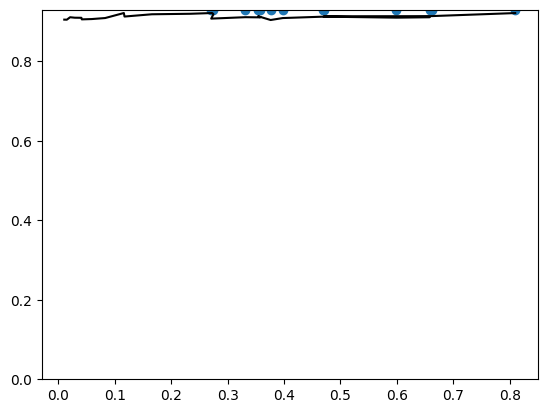

In [123]:
plt.scatter(xs, pred)
plt.plot(x_plot, y_plot, color='black')
plt.ylim([0, max(list(y_plot) + list(pred))])

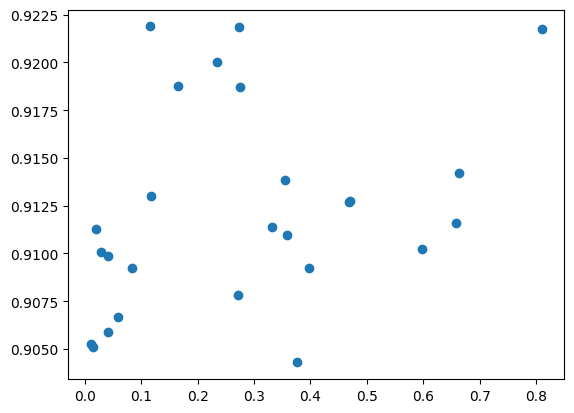

In [125]:
plt.scatter(x_plot, y_plot)